In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import plotly.express as px
import scipy as spy
import seaborn as sns

load data

In [11]:
data = pd.read_csv(".\HousingPrices-Amsterdam-August-2021.csv")

check if Unnamed:0 is index 

In [12]:
print(len(pd.unique(data["Unnamed: 0"])))
print(data["Unnamed: 0"])

924
0        1
1        2
2        3
3        4
4        5
      ... 
919    920
920    921
921    922
922    923
923    924
Name: Unnamed: 0, Length: 924, dtype: int64


check if unnamed: 0 containes nulls or nans

In [13]:
if len(data[pd.isnull(data["Unnamed: 0"])==True]) == 0:
    print("no nulls")
else:
    print("nulls")

if len(data[pd.isna(data["Unnamed: 0"])==True]) == 0:
    print("no nan")
else:
    print("nan")

print(data.info())

no nulls
no nan
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 924 entries, 0 to 923
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  924 non-null    int64  
 1   Address     924 non-null    object 
 2   Zip         924 non-null    object 
 3   Price       920 non-null    float64
 4   Area        924 non-null    int64  
 5   Room        924 non-null    int64  
 6   Lon         924 non-null    float64
 7   Lat         924 non-null    float64
dtypes: float64(3), int64(3), object(2)
memory usage: 57.9+ KB
None


unnamed:0 seems to be index<br>
check if unnamed:0 is continues<br>
comparing entries with  entry<br>
<br>
PRICE seems to contrain Null

In [14]:
hold = 1
for i in data["Unnamed: 0"]:
    if i == 1: 
        continue
    if i-1 == hold:
        hold += 1
if hold == len(data["Unnamed: 0"]):
    print("continues")

continues


unnamed:0 is contineous and will be renamed

In [15]:
data = data.rename(columns={"Unnamed: 0":"index"})

Clean up nans in prices<br>
<br>
show indecies of rows

In [16]:
data["Price"][pd.isnull(data["Price"])].index

Int64Index([73, 321, 610, 727], dtype='int64')

we will clear the 4 entries by deletion<br>
later we will approximate the value and prob. include them again

In [17]:
data = data.drop(data["Price"][pd.isnull(data["Price"])].index)

The first two digits indicate a city and a region, the second two digits and the two letters indicate a range of house numbers, usually on the same street. Consequently, a postal address is uniquely defined by the postal code and the house number. On average, a Dutch postal code comprises eight single addresses. 

breaking down zip code to "region"

In [18]:
data["Region"] = data["Zip"].str[0:4]

<AxesSubplot:>

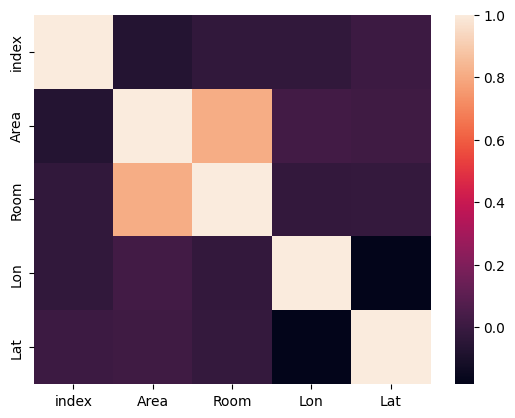

In [36]:
#first look at correlations
sns.heatmap(data.corr(method="pearson"))

In [73]:
median_price=data.groupby(["Region"]).median()["Price"].reset_index().sort_values(by="Region")

KeyError: 'Price'

In [ ]:
ordered_Regions_for_plot=median_price[["Price","Region"]].sort_values(by="Price")["Region"]

fig, ax = plt.subplots(figsize=(20,5))
fig1 = sns.barplot(x=median_price["Region"],y=median_price["Price"]/1000000,color="lightblue",order=ordered_Regions_for_plot)
fig1.set_xticklabels(labels=median_price["Region"],fontdict={"fontsize":"8","rotation":"-45"})
fig1.set_title("Median Price of each Region (by Zip)")
fig1.set_ylabel("Price (in M)")
fig1.set_xlabel("Region (Zip Code)")
plt.show()


In [22]:

geodata=json.load(open("./georef-netherlands-postcode-pc4_simple.geojson","r"))

#plotly needs specificly "id" within features so we have to copy them from properties to features
for i in geodata["features"]:
    i["id"]=i["properties"]["pc4_code"]

check if all zip codes of data are in geodata

In [23]:
#get only zip codes from data
zip_list = []
for i in geodata["features"]:
    zip_list.append(i["properties"]["pc4_code"])

#check if very zip code is present in geodata
for i in data["Region"].unique():
    if i not in zip_list:
        print(i)

In [24]:
avg_data = data.groupby(["Region"]).median().reset_index()[["Region","Price"]]

In [ ]:
fig2 = px.choropleth_mapbox(
    avg_data,
    locations=avg_data["Region"],
    geojson=geodata,color=avg_data["Price"],
    zoom=9.7, 
    center = {"lat": 52.356157, "lon": 4.907736},
    color_continuous_scale="matter", 
    mapbox_style="carto-positron",
    hover_data=avg_data,
    range_color=[avg_data["Price"].min(),avg_data["Price"].max()],
    width=1000,
    height=500
)

fig2.update_layout(                      
    margin={"r":0,"t":0,"l":0,"b":0}
)

fig2.show()

In [26]:

data.groupby(["Region"]).describe().reset_index()[["Price","Region"]][data.groupby(["Region"]).describe().reset_index()["Region"]=="1071"]

Price                                                                      \
   count       mean            std       min       25%        50%        75%   
41  10.0  1256500.0  556077.782329  550000.0  915000.0  1100000.0  1506250.0   

              Region  
          max         
41  2500000.0   1071

In [27]:
#data[["Price","Region"]].plot.hist(subplots=True,by="Region")

In [28]:
#create lists containing all prices for individual regions. This is to conduct norm. dist. test.
data_for_norm_test = data
data_for_norm_test["Price"] = data_for_norm_test["Price"].astype("str")

data_for_norm_test = data_for_norm_test.groupby(["Region"])["Price"].agg(",".join).reset_index()

In [29]:
data_for_norm_test

,Region,Price
0,1011,"1295000.0,439000.0,445000.0,875000.0,635000.0,..."
1,1012,"375000.0,340000.0,1450000.0,4495000.0,1450000...."
2,1013,"375000.0,1950000.0,450000.0,425000.0,325000.0,..."
3,1014,"950000.0,1250000.0,1450000.0,690000.0,475000.0"
4,1015,"469000.0,725000.0,915000.0,469000.0,950000.0,1..."
...,...,...
65,1104,"325000.0,285000.0,285000.0,375000.0,525000.0,6..."
66,1106,"325000.0,375000.0,320000.0,245000.0,270000.0,3..."
67,1107,"245000.0,395000.0,320000.0,250000.0,295000.0,3..."
68,1108,"325000.0,300000.0,350000.0"


In [30]:
#check price dist.
norm_test_results = []
norm_test_regions = []
for count,i in enumerate(data_for_norm_test["Price"]):
    temp = [float(t) for t in i.split(",")]
    if len(temp)<=8:
        continue
    norm_test_regions.append(data_for_norm_test["Region"][count])
    norm_test_results.append(spy.stats.normaltest(temp))

c:\Users\wolle\Desktop\amsterdam_house_price\envwin\lib\site-packages\scipy\stats\_stats_py.py:1769: UserWarning:

kurtosistest only valid for n>=20 ... continuing anyway, n=15

c:\Users\wolle\Desktop\amsterdam_house_price\envwin\lib\site-packages\scipy\stats\_stats_py.py:1769: UserWarning:

kurtosistest only valid for n>=20 ... continuing anyway, n=19

c:\Users\wolle\Desktop\amsterdam_house_price\envwin\lib\site-packages\scipy\stats\_stats_py.py:1769: UserWarning:

kurtosistest only valid for n>=20 ... continuing anyway, n=14

c:\Users\wolle\Desktop\amsterdam_house_price\envwin\lib\site-packages\scipy\stats\_stats_py.py:1769: UserWarning:

kurtosistest only valid for n>=20 ... continuing anyway, n=12

c:\Users\wolle\Desktop\amsterdam_house_price\envwin\lib\site-packages\scipy\stats\_stats_py.py:1769: UserWarning:

kurtosistest only valid for n>=20 ... continuing anyway, n=13

c:\Users\wolle\Desktop\amsterdam_house_price\envwin\lib\site-packages\scipy\stats\_stats_py.py:1769: UserWarni

In [31]:
#regions with no normal dist.
for i in zip(norm_test_results,norm_test_regions):
    
    if i[0][1] <= 0.05:
        print(i[1])

1011
1012
1013
1015
1016
1017
1018
1019
1024
1025
1052
1053
1054
1058
1060
1061
1065
1067
1068
1069
1075
1076
1082
1091
1095
1103
